In [44]:
import numpy as np
from qiskit import *
from qiskit.circuit.library import ZZFeatureMap,TwoLocal
from qiskit_machine_learning.circuit.library import RawFeatureVector
from qiskit.circuit import ParameterVector
from qiskit_machine_learning.neural_networks import EstimatorQNN

In [33]:
def encode_circ_zz(reg_a,reg_b,num_features = 2):
    qc = QuantumCircuit(reg_a,reg_b)
    qc.compose(ZZFeatureMap(num_features*2),inplace=True)
    
    return qc

def encode_circ(input_dimension = 4,param_name = ''):
    #vec = ParameterVector(param_name,input_dimension)
    #qc = RawFeatureVector((input_dimension))
    #qc.assign_parameters(vec,inplace=True)

    np.random.seed(0)
    initial_point = np.random.rand(input_dimension)
    initial_point /= np.linalg.norm(initial_point)
    #qc.bind_parameters({qc.parameters[i]:initial_point[i] for i in range(qc.num_parameters)})
    #qc.assign_parameters(initial_point,inplace=True)
    qc = QuantumCircuit(2)
    qc.initialize(initial_point)
    return qc

In [20]:
def entangle_circ(reg_a,reg_b,num_features = 2):
    qc = QuantumCircuit(reg_a,reg_b)
    qc.compose(TwoLocal(num_features * 2,reps = 1,rotation_blocks = 'ry',entanglement_blocks = 'cx',skip_final_rotation_layer = True),inplace=True)
    return qc

In [21]:
def measure_circ(reg_a,reg_b,reg_c, num_features = 2):
    
    mc = QuantumCircuit(reg_a,reg_b,reg_c)

    #Perform controlled SWAP test for measuring entanglement

    for i in range(num_features):
        mc.cx( reg_a[i],reg_b[i])
        mc.h(reg_c[i])

    for i in range(num_features):
        mc.ccx(reg_b[i],reg_c[i],reg_a[i])
        
    for i in range(num_features):
        mc.cx(reg_a[i],reg_b[i])
        mc.h(reg_c[i])
    return mc

In [39]:
def calculate_entanglement(num_features,results):
    desired = ''.join(['0' for i in range(num_features)])
    return 1- results[desired]/sum(results.values())

In [58]:
num_features = 2

reg_a = QuantumRegister(num_features)
reg_b = QuantumRegister(num_features)
reg_c = QuantumRegister(num_features)
output = ClassicalRegister(num_features)
qc = QuantumCircuit(reg_a,reg_b,reg_c,output)
# qc.compose(encode_circ(input_dimension=4,param_name='reg_a'),inplace=True,qubits=reg_a)
# qc.compose(encode_circ(input_dimension=4,param_name='reg_b'),inplace=True,qubits=reg_b)
fm = encode_circ_zz(reg_a,reg_b)
qc.compose(fm,inplace=True)
pqc = entangle_circ(reg_a,reg_b)
qc.compose(pqc,inplace=True)
qc.compose(measure_circ(reg_a,reg_b,reg_c),inplace=True)

#qc.measure(reg_c,output)
qc.draw()

┌────────────────────────────────────┐»
q22554_0: ┤0                                   ├»
          │                                    │»
q22554_1: ┤1                                   ├»
          │  ZZFeatureMap(x[0],x[1],x[2],x[3]) │»
q22555_0: ┤2                                   ├»
          │                                    │»
q22555_1: ┤3                                   ├»
          └───────────────┬───┬────────────────┘»
q22556_0: ────────────────┤ H ├─────────────────»
                          ├───┤                 »
q22556_1: ────────────────┤ H ├─────────────────»
                          └───┘                 »
    c8: 2/══════════════════════════════════════»
                                                »
«          ┌────────────────────────────────┐          ┌───┐               
«q22554_0: ┤0                               ├──■───────┤ X ├───────■───────
«          │                                │  │       └─┬─┘┌───┐  │       
«q22554_1: ┤1                               ├──┼────■────┼──┤ X ├──┼────■──
«          │  TwoLocal(θ[0],θ[1],θ[2],θ[3]) │┌─┴─┐  │    │  └─┬─┘┌─┴─┐  │  
«q22555_0: ┤2                               ├┤ X ├──┼────■────┼──┤ X ├──┼──
«          │                                │└───┘┌─┴─┐  │    │  └───┘┌─┴─┐
«q22555_1: ┤3                               ├─────┤ X ├──┼────■───────┤ X ├
«          └────────────────────────────────┘     └───┘  │    │  ┌───┐└───┘
«q22556_0: ──────────────────────────────────────────────■────┼──┤ H ├─────
«                                                             │  ├───┤     
«q22556_1: ───────────────────────────────────────────────────■──┤ H ├─────
«                                                                └───┘     
«    c8: 2/════════════════════════════════════════════════════════════════
«

In [66]:
from qiskit.quantum_info import SparsePauliOp

o1 = SparsePauliOp.from_list([("I"*2*num_features+"X"*num_features,1)])

qnn = EstimatorQNN(
    circuit=qc,
    input_params=fm.parameters,
    weight_params=pqc.parameters,
    observables = o1
)

qnn.forward(input_data=[1,1,1,1],weights=[1, 2, 3, 4])

array([[-0.01509353]])

In [45]:
from qiskit.circuit import Parameter

circuit = qc.bind_parameters({param: np.random.uniform(0.0,np.pi*2) for param in qc.parameters})
random_input = [np.random.uniform(0,np.pi*2) for i in range(num_features * 2)]
#circuit.draw()


In [40]:
# Import Aer
from qiskit import Aer,execute

# Run the quantum circuit on a statevector simulator backend
backend = Aer.get_backend('qasm_simulator')

def objective_function(parameters):

    circuit = qc.bind_parameters({pqc.parameters[i]:parameters[i] for i in range(pqc.num_parameters)})

    #circuit.draw()
    # Run
    result = execute(circuit,backend).result()
    return calculate_entanglement(2,result.get_counts(circuit))

In [41]:
objective_function(initial_point)

0.533203125

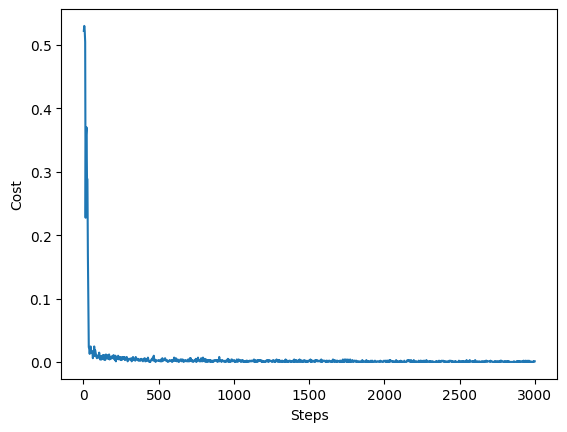

0.0


In [43]:
from qiskit.algorithms.optimizers import SPSA
import matplotlib.pyplot as plt

class OptimizerLog:
    """Log to store optimizer's intermediate results"""
    def __init__(self):
        self.evaluations = []
        self.parameters = []
        self.costs = []
    def update(self, evaluation, parameter, cost, _stepsize, _accept):
        """Save intermediate results. Optimizer passes five values
        but we ignore the last two."""
        self.evaluations.append(evaluation)
        self.parameters.append(parameter)
        self.costs.append(cost)

initial_point = [np.random.uniform(0.0,np.pi*2) for i in range(qc.num_parameters)]
log = OptimizerLog()
optimizer = SPSA(maxiter=1000,callback=log.update)
result = optimizer.minimize(objective_function, initial_point)

fig = plt.figure()
plt.plot(log.evaluations, log.costs)
plt.xlabel('Steps')
plt.ylabel('Cost')
plt.show()

print(result.fun)

In [10]:
qc_1 = QuantumCircuit(reg_a,name="first input")
vec_1 = ParameterVector('vec_1',4)
qc_1.compose(RawFeatureVector((4)),inplace=True)
qc_1.assign_parameters(vec_1,inplace=True)
qc_1.parameters

ParameterView([ParameterVectorElement(vec_1[0]), ParameterVectorElement(vec_1[1]), ParameterVectorElement(vec_1[2]), ParameterVectorElement(vec_1[3])])